In [5]:
%matplotlib inline
import pandas as pd
import numpy as np

In [203]:
rating1 = pd.read_csv('jester-data-1.csv', header=None)
rating2 = pd.read_csv('jester-data-2.csv', header=None)
rating3 = pd.read_csv('jester-data-3.csv', header=None)
rating = pd.concat([rating1, rating2, rating3]).reset_index()
del rating[0]
del rating['index']
rating.shape

(73421, 100)

In [204]:
d = rating.replace(99, np.nan)
d.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [205]:
nan_col = d.isnull().sum()
d_ordered = d[nan_col.sort_values().index]

In [206]:
nan_col_i = d_ordered.isnull().sum(axis=1)
d_ordered_i = d_ordered.loc[nan_col_i.sort_values().index]

In [207]:
nan_col_i.sort_values().index

Int64Index([29517, 20804, 10311, 41653, 10313, 10314, 10315, 35079, 41652,
            10318,
            ...
            69279, 49028, 62255, 62251, 71890, 62282, 49937, 53238, 56999,
            49752],
           dtype='int64', length=73421)

In [143]:
d = rating.replace(99, np.nan)
d = d.as_matrix()[:, 1:]
d = np.nan_to_num(d, 0)
d = d > 2.5
d = d.astype(int)

In [208]:
d_ordered_i.head()

,17,8,20,15,19,5,13,18,7,16,...,77,80,100,78,76,75,74,72,73,71
29517,-3.88,1.21,-6.12,-4.47,2.48,3.93,-4.47,6.60,-6.12,-0.10,...,3.83,-3.79,-3.93,5.53,7.09,2.67,-1.46,4.08,0.29,7.23
20804,-0.44,1.75,2.28,-3.74,-3.40,4.71,-3.45,-2.62,-0.49,3.64,...,2.82,0.15,4.27,4.13,-1.99,6.07,4.03,6.70,4.08,6.31
10311,-3.54,-0.53,0.58,0.97,-0.39,-1.75,-1.41,1.84,3.06,-3.30,...,-1.65,5.97,0.44,1.17,7.04,0.87,2.14,4.61,2.33,4.85
41653,-6.55,-6.50,-9.85,0.49,-5.29,-0.10,-0.97,-9.56,2.57,-9.66,...,3.25,4.85,1.99,5.15,-7.67,-7.38,-7.43,3.45,6.21,-9.42
10313,-0.24,5.63,-4.22,0.29,-1.94,2.72,5.87,-1.89,-1.80,-1.94,...,1.84,-0.24,0.29,1.84,1.55,0.97,2.28,4.13,-0.19,8.35


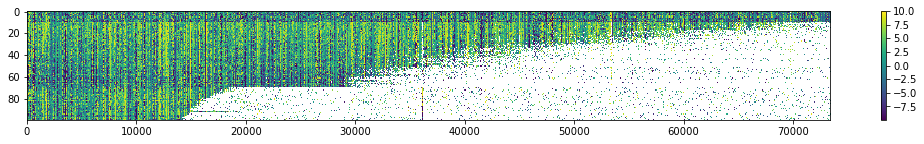

In [210]:
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow(d_ordered_i.as_matrix().transpose(), aspect='auto')
plt.colorbar()

In [85]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

In [97]:
# this is the size of our encoded representations
encoding_dim = 8

# this is our input placeholder
x = Input(shape=(100,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu', use_bias=False)(x)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(100, activation='tanh', use_bias=False)(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(x, decoded)

In [98]:
# this model maps an input to its encoded representation
encoder = Model(x, encoded)

In [99]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [100]:
autoencoder.compile(optimizer='adadelta', loss='mean_absolute_error')

In [101]:
np.random.shuffle(d)
training, test = d[:60000,:], d[60000:,:]

In [102]:
from keras.callbacks import TensorBoard
from datetime import datetime

In [104]:
datestr = str(datetime.now()).replace(':', '-').split('.')[0]

autoencoder.fit(training, training,
                epochs=50,
                verbose=2,
                batch_size=256,
                validation_data=(test, test),
                callbacks=[TensorBoard(log_dir='tmp\\tanh-layers1-nodes' + str(encoding_dim) + datestr)])

Train on 60000 samples, validate on 13421 samples
Epoch 1/50
0s - loss: 0.2374 - val_loss: 0.2366
Epoch 2/50
0s - loss: 0.2374 - val_loss: 0.2366
Epoch 3/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 4/50
0s - loss: 0.2374 - val_loss: 0.2366
Epoch 5/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 6/50
0s - loss: 0.2374 - val_loss: 0.2366
Epoch 7/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 8/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 9/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 10/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 11/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 12/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 13/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 14/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 15/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 16/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 17/50
1s - loss: 0.2374 - val_loss: 0.2366
Epoch 18/50
0s - loss: 0.2373 - val_loss: 0.2366
Epoch 19/50
1s - loss: 0.2373 - val_loss: 0.2366
Epoch 20/50
0s - loss: 0.237

In [105]:
# encode and decode some digits
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(test)
# decoded_imgs = decoder.predict(encoded_imgs
decoded_imgs = autoencoder.predict(test)

In [106]:
import matplotlib.pyplot as plt

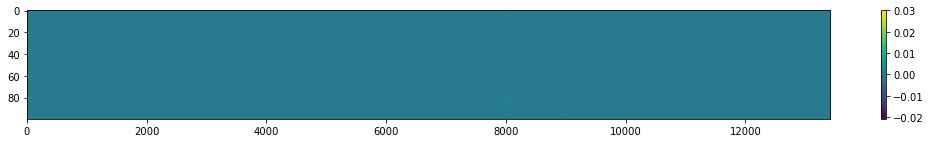

In [107]:
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow(decoded_imgs.transpose(), aspect='auto')
plt.colorbar()

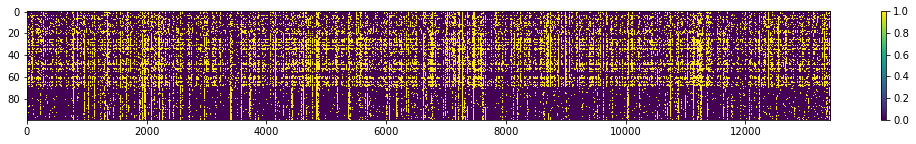

In [108]:
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow(test.transpose(), aspect='auto')
plt.colorbar()

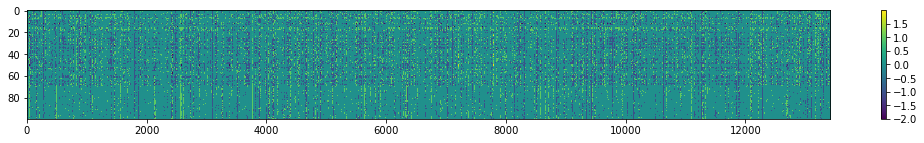

In [69]:
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow((decoded_imgs-test).transpose(), aspect='auto')
plt.colorbar()

In [70]:
decoded_imgs

array([[  2.06654266e-04,  -1.92616979e-04,   2.87509203e-04, ...,
          4.56139009e-04,  -2.91043863e-04,  -1.88541861e-04],
       [  2.79127707e-04,  -2.45828851e-04,   2.52417260e-04, ...,
          6.21883024e-04,  -5.10425656e-04,  -3.62766325e-04],
       [  2.06648881e-04,  -1.92648644e-04,   2.87849427e-04, ...,
          4.56112379e-04,  -2.90736178e-04,  -1.88260427e-04],
       ..., 
       [  2.19422439e-03,  -2.04534573e-03,   3.05430731e-03, ...,
          4.84311907e-03,  -3.08888988e-03,  -2.00065156e-03],
       [  4.83651558e-04,  -1.63634077e-01,  -4.26531971e-01, ...,
          6.49123732e-03,  -5.61936572e-03,  -4.31129849e-03],
       [  6.71736838e-04,  -5.91601187e-04,   6.07456604e-04, ...,
          1.49659626e-03,  -1.22836838e-03,  -8.73017823e-04]], dtype=float32)

In [71]:
liked = np.round(decoded_imgs)
test_liked = test

In [72]:
# Rough accuracy
sum(sum(liked == test_liked))/(liked.shape[0]*liked.shape[1])

0.77295432531107966

In [73]:
# Score error
sum(sum(abs(test_liked-liked))/(liked.shape[0]*liked.shape[1]))

0.22817003203934128

In [74]:
# Absolute error
sum(sum(abs(test-decoded_imgs))/(liked.shape[0]*liked.shape[1]))

0.23100592745590959

In [75]:
# Save the model
autoencoder.save('single-layer-n8-tanh-activation.h5')

In [76]:
autoencoder.predict(np.zeros((1, 100)))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [53]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

In [52]:
decoded_imgs.min()

-0.26814115

In [55]:
def custom_activation(x):
    return K.hard_sigmoid(x-2.5)